<h1 align="center">OpenMP part 2</h1> 

In [31]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
import timeit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

   Temps elapsed              : 0.0029158592224121094 
    Temps CPU                  : 0.017418827000028614 



/tmp/ipykernel_7851/4083140249.py:96: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_7851/4083140249.py:102: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


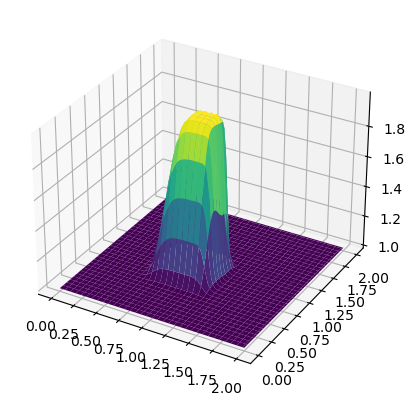

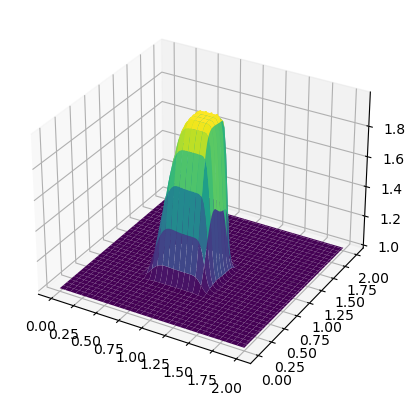

In [43]:
@types('float[:,:]', 'float[:,:]','float[:,:]', 'float[:,:]', 'int', 'float','float', 'float','float')
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy, c):
     
    #$ omp parallel
    
    #$ omp sections nowait
    #$ omp section
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    #$ omp end section
    
    #$ omp section 
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    #$ omp end section
    
    #$ omp section
    row, col = u.shape
    #$ omp end section
    #$ omp end sections
    
    
    #$ omp for 
    for n in range(nt):
        un[: , :]=u[: , :]
        vn[: , :]=v[: , :]
        for i in range(1,row):
            for j in range(1,col):
                u[i , j]= un[ i , j] - un[ i , j] * dt / dx * (un[i , j] - un[i-1 , j]) - vn[ i , j] * dt / dy * (un[i , j] - un[i , j-1]) 
                v[i , j]= vn[ i , j] - un[ i , j] * dt / dx * (vn[i , j] - vn[i-1 , j]) - vn[ i , j] * dt / dy * (vn[i , j] - vn[i , j-1])
      
   
    #$ omp sections nowait
    #$ omp section    
    u[0, :] = 1
    u[col-1, :] = 1
    u[:, 0] = 1
    u[:, row-1] = 1  
    #$ omp end section 
    #$ omp section 
    v[0, :] = 1
    v[col-1, :] = 1
    v[:, 0] = 1
    v[:, row-1] = 1  
    #$ omp end section 
    #$ omp end sections
    
    #$ omp end parallel
    return 0

if __name__=="__main__":
    from pyccel.stdlib.internal.openmp import omp_set_num_threads
    omp_set_num_threads(4)

    from pyccel.epyccel import epyccel
    p_nonlinearconv = epyccel(solve_2d_nonlinearconv_pure, language='c', accelerators=['openmp'])
    
    ###variable declarations
    nx = 101
    ny = 101
    nt = 80
    c = 1.
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx

    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    u = np.ones((ny, nx)) ##create a 1xn vector of 1's
    v = np.ones((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx))  
    
     # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    
    p_nonlinearconv(u, un, v, vn, nt, dt, dx, dy, c)
    
     # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

   
    # Print result
    print(
	  "   Temps elapsed              :", t_elapsed, "\n",
	  "   Temps CPU                  :", tcpu,      "\n",
    )

    fig = pyplot.figure(figsize=(7, 5), dpi=100)
    ax = fig.gca(projection='3d')                      
    X, Y = np.meshgrid(x, y)                            
    surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


    fig = pyplot.figure(figsize=(7, 5), dpi=100)
    ax = fig.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

Text(0.5, 1.0, 'Time CPU per number of thread')

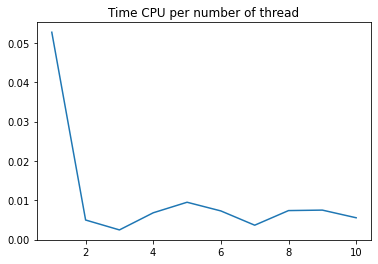

In [15]:
time_CPU=[0.05273, 0.00496, 0.00244, 0.00680, 0.00948, 0.00727, 0.00364, 0.00736, 0.00748, 0.00553]
pyplot.plot(range(1,11),time_CPU)
pyplot.title('Time CPU per number of thread')

On remarque que le temps de calcule est plus restreint quand on augment le nombre de thread comparé à l'exécution séquentielle où il n'y a qu'un seul thread qui entre en jeu. Par ailleur, on remarque qu'au dela de 3 threads, les performances en terme de temps ne s'améliorent plus.

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [16]:
%%file naviestock.py

from pyccel.decorators import types

@types('float[:,:]','float','float','float[:,:]','float[:,:]','float','float')
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    
    #$ omp parallel 
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    #$omp end parallel



@types('float[:,:]','float','float','float[:,:]','int','int')
def pressure_poisson_numba(p, dx, dy, b, nit , nt):
    import numpy as np
    row, col=p.shape
    
    pn = np.empty_like(p)
 
    #$ omp parallel
    #$ omp for
    for q in range(nt):
        for i in range(row):
            for j in range(col):
                pn[i,j] = p[i,j]
        for i in range(1,row-1):
            for j in range(1,col-1):
    
                    p[i, j] = (((pn[i+1, j] + pn[i-1, j]) * dy**2 + 
                                      (pn[i, j+1] + pn[i, j-1]) * dx**2) /
                                      (2 * (dx**2 + dy**2)) -
                                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                      b[i,j])
 
    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2
    
    #$ omp end parallel

        
@types('float[:,:]', 'float[:,:]','float','int','int','float','float','float[:,:]','float','float','int','int')
def cavity_flow_numba(u, v, dt, nx, ny, dx, dy, p, rho, nu, nit, nt):
    import numpy as np
    row1,col1=u.shape
    row2,col2=v.shape
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.empty((ny, nx),dtype=np.double)
     
    #$ omp parallel
    #$ omp for
    for n in range(nt):
        for i in range(row1):
            for j in range(col1):
                un[i,j]= u[i,j]
        for i in range(row2):
            for j in range(col2):
                vn[i,j]= v[i,j]
        
        build_up_b_numba(b, rho, dt, u, v, dx, dy)
        pressure_poisson_numba(p, dx, dy, b, nit, nt)
        
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
    
       
    
        
    #$ omp end parallel
    
       
 

Overwriting naviestock.py


   Temps elapsed              : 0.31149768829345703 
    Temps CPU                  : 2.404824908000009 



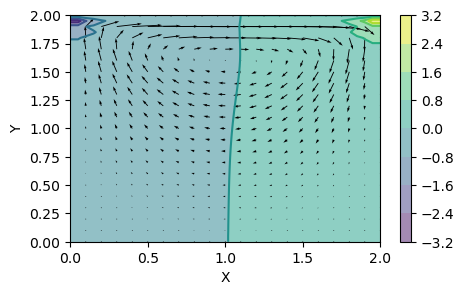

In [29]:
if __name__ == '__main__':
    from pyccel.stdlib.internal.openmp import omp_get_thread_num, omp_get_num_threads, omp_set_num_threads
    omp_set_num_threads(8)
    


    import naviestock
    from pyccel.epyccel import epyccel
    from pyccel.decorators import types
    naviestock_py= epyccel(naviestock, language='fortran',accelerators=['openmp'])
    import time, math
    
    nx = 41
    ny = 41
    nt = 500
    nit = 50
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    X, Y = np.meshgrid(x, y)

    rho = 1.
    nu = .1
    dt = .001

    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx)) 
    b = np.empty((ny, nx),dtype=np.double)
    
     # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------
    naviestock_py.cavity_flow_numba(u, v, dt, nx, ny, dx, dy, p, rho, nu, nit,nt)
     # ------------------ End computing ----------------
   
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

   
    # Print result
    print(
	  "   Temps elapsed              :", t_elapsed, "\n",
	  "   Temps CPU                  :", tcpu,      "\n",
    )

    fig = pyplot.figure(figsize=(5, 3), dpi=100)
    pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
    pyplot.colorbar()
    pyplot.contour(X, Y, p, cmap=cm.viridis)
    pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
    pyplot.xlabel('X')
    pyplot.ylabel('Y')
    
    

Text(0.5, 1.0, 'Time CPU per number of thread for Navies-Stock equation')

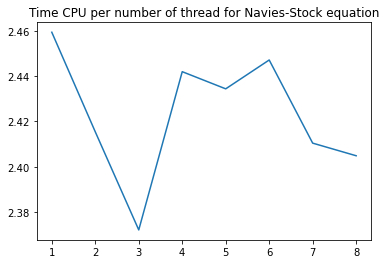

In [30]:
CPU_time=[2.45931, 2.41538, 2.37210, 2.44191, 2.43434, 2.44707, 2.41039, 2.40482]
pyplot.plot(range(1,9),CPU_time)
pyplot.title('Time CPU per number of thread for Navies-Stock equation')

On remarque que le temps de calcule est plus restreint quand on augment le nombre de thread comparé à l'exécution séquentielle où il n'y a qu'un seul thread qui entre en jeu. Par ailleur, on remarque qu'au dela de 3 threads, les performances en terme de temps ne s'améliorent plus.